In [1]:
import pandas as pd 
import numpy as np
import sys
import math

In [2]:
gldDf = pd.read_csv(r"C:\Users\Conno\OneDrive\College\Classes\9\FI515\GLD_Monthly.csv")
spyDf = pd.read_csv(r"C:\Users\Conno\OneDrive\College\Classes\9\FI515\SPY_MONTHLY.csv")
hygDf = pd.read_csv(r"C:\Users\Conno\OneDrive\College\Classes\9\FI515\HYG_MONTHLY.csv")

print(list(spyDf.columns.values))
# print(fullExcel)

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


## Calculating each month's return

I'm doing each ETF's returns in separate cells so that if one fails I don't have to rerun all of them

In [3]:

# Initializing variables
prevMonth = 1
thisMonth = 1

SPYreturns = []

# Populate the SPY Returns
for i, spyDfRow in spyDf.iterrows():
    prevMonth = thisMonth
    thisMonth = spyDfRow['Adj Close']
    thisMonthReturn = thisMonth / prevMonth - 1
    if i == 0:
        continue
    SPYreturns.append(thisMonthReturn)


In [4]:

# Re-Initializing variables
prevMonth = 1
thisMonth = 1

GLDreturns = [] 

# Populate the GLD Returns
for i, gldDfRow in gldDf.iterrows():
    prevMonth = thisMonth
    thisMonth = gldDfRow['Adj Close']
    thisMonthReturn = thisMonth / prevMonth - 1
    if i == 0:
        continue
    GLDreturns.append(thisMonthReturn)


In [5]:

# Re-Initializing variables
prevMonth = 1
thisMonth = 1

HYGreturns = []

# Populate the HYG Returns
for i, hygDfRow in hygDf.iterrows():
    prevMonth = thisMonth
    thisMonth = hygDfRow['Adj Close']
    thisMonthReturn = thisMonth / prevMonth - 1
    if i == 0:
        continue
    HYGreturns.append(thisMonthReturn)


## Setting Weights and Finding Combined Returns

In [6]:


# The following method returns a list of the combined returns given weights
# This assumes all DFs have the same length and range of dates
def CombinedReturnsGivenWeights(wGLD, wSPY, wHYG):
    combinedReturns = []
    for i in range(0, len(SPYreturns)):
        thisCombinedReturn = wGLD * GLDreturns[i] + wSPY * SPYreturns[i] + wHYG * HYGreturns[i]
        combinedReturns.append(thisCombinedReturn)
        
    return combinedReturns

statsIndexOfAverage = 0
statsIndexOfStdDev = 1

# Returns a list with 2 indices: 1. The average return, 2. the standard deviation
def GetStatsFromCombinedReturns(combReturns):
    averageReturn = sum(combReturns) / len(combReturns)
    variance = sum([((i - averageReturn) ** 2) for i in combReturns]) / len(combReturns)
    stdDev = variance ** 0.5

    return [averageReturn, stdDev]



In [7]:

# Some test weights
weightGLD = .50
weightHYG = .20
weightSPY = 1 - weightHYG - weightGLD

a = CombinedReturnsGivenWeights(weightGLD, weightSPY, weightHYG)
b = CombinedReturnsGivenWeights(0, 0, 1)

aStats = GetStatsFromCombinedReturns(a)
bStats = GetStatsFromCombinedReturns(b)

print("Stats for a:\n", aStats[statsIndexOfAverage], " | StdDev: ", aStats[statsIndexOfStdDev])
print("Stats for b:\n", bStats[statsIndexOfAverage], " | StdDev: ", bStats[statsIndexOfStdDev])

Stats for a:
 0.006040448459098796  | StdDev:  0.02893450118552849
Stats for b:
 0.005262617808006406  | StdDev:  0.020596770061139358


## Now to work on the optimizations

This is wildly inefficient. There's almost definitely a better way, but the dataset is small so I can get away with it

In [8]:

def OptimizeAverage(givenStdDev = None):
    # Initialize to a super negative number to make sure that it gets overwritten
    maxAverage = -(sys.float_info.max - 2)
    stdDevOfBestAverage = 0

    comparisonValue = 0
    # Determine if we need to maintain a specific average
    if givenStdDev != None:
        comparisonValue = round(givenStdDev * 10000)/10000

    bestGLDWeight = 0
    bestSPYWeight = 0
    bestHYGWeight = 0

    for i in np.arange(0, 1, 0.01):
        for j in np.arange(0, 1 - i, 0.01):
            k = 1 - i - j

            currentCombinedReturns = CombinedReturnsGivenWeights(i, j, k)
            currentStats = GetStatsFromCombinedReturns(currentCombinedReturns)  

            currentStdDev = currentStats[statsIndexOfStdDev]
            currentAverage = currentStats[statsIndexOfAverage]
            
            if currentAverage >= maxAverage and (givenStdDev == None or round(currentStdDev * 10000)/10000 == comparisonValue):
                bestGLDWeight = i
                bestSPYWeight = j
                bestHYGWeight = k

                maxAverage = currentAverage
                stdDevOfBestAverage = currentStdDev

    return {
        "StdDev" : stdDevOfBestAverage,
        "Average" : maxAverage,
        "GLDWeight" : bestGLDWeight,
        "SPYWeight" : bestSPYWeight,
        "HYGWeight" : bestHYGWeight
    }

OptimizeAverage()

{'StdDev': 0.03848549313117964,
 'Average': 0.01394713336674889,
 'GLDWeight': 0.0,
 'SPYWeight': 0.99,
 'HYGWeight': 0.010000000000000009}

In [9]:

def OptimizeStdDev(givenAverage = None):
    # Initialize to a super positive number to make sure that it gets overwritten
    minStdDev = sys.float_info.max - 2
    avgOfMinStdDev = 0

    comparisonValue = 0
    # Determine if we need to maintain a specific average
    if givenAverage != None:
        comparisonValue = round(givenAverage * 10000)/10000

    bestGLDWeight = 0
    bestSPYWeight = 0
    bestHYGWeight = 0

    for i in np.arange(0, 1, 0.01):
        for j in np.arange(0, 1 - i, 0.01):
            k = 1 - i - j

            currentCombinedReturns = CombinedReturnsGivenWeights(i, j, k)
            currentStats = GetStatsFromCombinedReturns(currentCombinedReturns)

            currentStdDev = currentStats[statsIndexOfStdDev]
            currentAverage = currentStats[statsIndexOfAverage]
            
            if currentStdDev <= minStdDev and (givenAverage == None or round(currentAverage * 10000)/10000 == comparisonValue):
                bestGLDWeight = i
                bestSPYWeight = j
                bestHYGWeight = k

                minStdDev = currentStdDev
                avgOfMinStdDev = currentAverage

    return {
        "StdDev" : minStdDev,
        "Average" : avgOfMinStdDev,
        "GLDWeight" : bestGLDWeight,
        "SPYWeight" : bestSPYWeight,
        "HYGWeight" : bestHYGWeight
    }

OptimizeStdDev(.006)

{'StdDev': 0.021297335009892344,
 'Average': 0.005954457528784305,
 'GLDWeight': 0.05,
 'SPYWeight': 0.1,
 'HYGWeight': 0.85}

In [10]:
OptimizeAverage()

{'StdDev': 0.03848549313117964,
 'Average': 0.01394713336674889,
 'GLDWeight': 0.0,
 'SPYWeight': 0.99,
 'HYGWeight': 0.010000000000000009}

In [11]:
OptimizeStdDev()

{'StdDev': 0.020282783077293216,
 'Average': 0.004966003291151251,
 'GLDWeight': 0.08,
 'SPYWeight': 0.0,
 'HYGWeight': 0.92}

In [12]:
OptimizeStdDev(.011)

{'StdDev': 0.030935227113256684,
 'Average': 0.010954633153514826,
 'GLDWeight': 0.05,
 'SPYWeight': 0.67,
 'HYGWeight': 0.2799999999999999}

In [13]:
stdDevs = []
averages = []

for i in np.arange(.002,.013,.0001):
    stdDevs.append(OptimizeStdDev(i)["StdDev"])
    averages.append(i)

print(stdDevs)

[0.03996519080841734, 0.03884124920800809, 0.03809859806613818, 0.036995386396406774, 0.035906150175576836, 0.03518839841598085, 0.03412544014693948, 0.03308028889172886, 0.03239426652812402, 0.03138276004691008, 0.030394149407839653, 0.02943074199009548, 0.028803723777286135, 0.027888134316024014, 0.027005168646322863, 0.026436268478193706, 0.025615164753867763, 0.02483615520731392, 0.024342205960034797, 0.02364255078124311, 0.022996412539435577, 0.022597668094010193, 0.022051046729264476, 0.021570356654972353, 0.021160091596837658, 0.02092778126332146, 0.020643897284625953, 0.020440316225251758, 0.02035043753070996, 0.02028560120652923, 0.020282783077293216, 0.020330765333421923, 0.02040953039490128, 0.020499734105734083, 0.02062708301001665, 0.02072047195645214, 0.02081688951934831, 0.020942675185579625, 0.021070123459472682, 0.02117637036788433, 0.021297335009892344, 0.02145661982083457, 0.021573042234809846, 0.02169214823295701, 0.02184604537963102, 0.02199721167207854, 0.02212496

In [14]:
print(len(stdDevs))

0.03996519080841734
0.03884124920800809
0.03809859806613818
0.036995386396406774
0.035906150175576836
0.03518839841598085
0.03412544014693948
0.03308028889172886
0.03239426652812402
0.03138276004691008
0.030394149407839653
0.02943074199009548
0.028803723777286135
0.027888134316024014
0.027005168646322863
0.026436268478193706
0.025615164753867763
0.02483615520731392
0.024342205960034797
0.02364255078124311
0.022996412539435577
0.022597668094010193
0.022051046729264476
0.021570356654972353
0.021160091596837658
0.02092778126332146
0.020643897284625953
0.020440316225251758
0.02035043753070996
0.02028560120652923
0.020282783077293216
0.020330765333421923
0.02040953039490128
0.020499734105734083
0.02062708301001665
0.02072047195645214
0.02081688951934831
0.020942675185579625
0.021070123459472682
0.02117637036788433
0.021297335009892344
0.02145661982083457
0.021573042234809846
0.02169214823295701
0.02184604537963102
0.02199721167207854
0.022124965383920343
0.022273292502587687
0.0224577486242

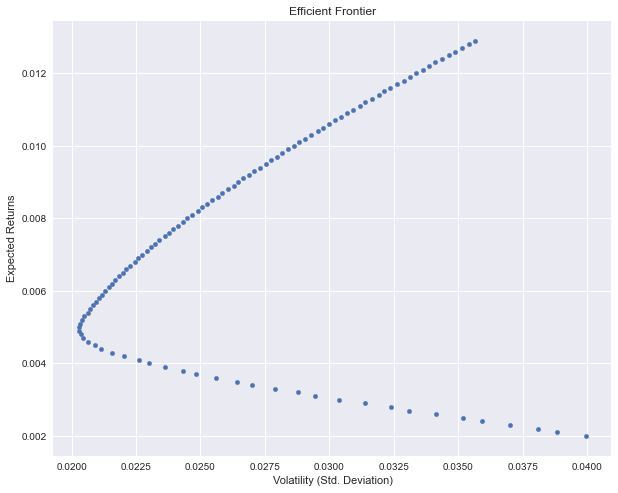

In [15]:
import matplotlib.pyplot as plt

df = pd.DataFrame()

df["Standard_Deviations"] = stdDevs
df["Averages"] = averages

plt.style.use('seaborn')
df.plot.scatter(y='Averages', x='Standard_Deviations', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()